In [606]:
import numpy as np
import skimage
import pickle
import matplotlib.pyplot as plt
import skimage.transform
from random import random
from scipy import stats
from scipy.spatial.distance import cityblock
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers

In [607]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

"""OPENING ALL THE FILES INTO ONE ARRAY - An Array of 50000 by 3072 """

a= 'D:/cifar-10-python/data_batch_1'
b= 'D:/cifar-10-python/data_batch_2'
c= 'D:/cifar-10-python/data_batch_3'
d= 'D:/cifar-10-python/data_batch_4'
e= 'D:/cifar-10-python/data_batch_5'

#Adding All Files into one Array
datadict = unpickle(a)
X = datadict["data"].astype("uint8") #Basic Data Set with 10,000 rows and 3072 columns
Y = datadict["labels"] #contains the number associated with label name

for i in [b,c,d,e]:
    datadict = unpickle(i)
    X1 = datadict["data"].astype("uint8") #Basic Data Set with 10,000 rows and 3072 columns
    Y1 = datadict["labels"] #contains the number associated with label name

    X = np.vstack((X,X1)) # Vertical Stack
    Y = np.hstack((Y,Y1)) # horizontal Stack
  
"""BRINGING IN THE LABEL DATA"""

#number from labels associates with one of the 10 names in this
labeldict = unpickle('D:/cifar-10-python/batches.meta')
label_names = labeldict["label_names"] 

Z = X #Simplified, just 50,000 rows and 3072 columns

# #Reshaping the data to view it in R,G,B arrays and print the image as well, previous data was just rows of bytes
X = X.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 
Y = np.array(Y)


"""BRINGING IN THE TEST DATA"""

#Bringing in Test Data
testdict = unpickle('D:/cifar-10-python/test_batch')
testdict.keys()
X_test = testdict['data'].astype("uint8")
Y_test = np.array(testdict['labels']) #Must convert to array before working

Z_test = X_test #Simplified form of 10,000 x 3072 

# #Reshaping the data to view it, previous data was just rows of bytes
X_test = X_test.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 
Y_test = np.array(Y_test)

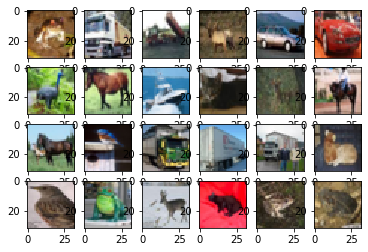

In [608]:
"""CODE FOR SHOWING THE IMAGES """

#Plotting Some Images 
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(X[i])
plt.show()

# for i in range(X.shape[0]):
#     # Show some images randomly
#     if random() > 0.999:
#         plt.figure(1);
#         plt.clf()
#         plt.imshow(X[i])
#         plt.title(f"Image {i} label={label_names[Y[i]]} (num {Y[i]})")
#         plt.pause(0.5)


In [609]:
"""
SPLITTING INTO TEST AND TRAIN DATA (Smaller sets are taken during development phase)
"""
X_train = X/255 #Normalizing the test and train images for better accuracies
X_test = X_test/255
Y_train = Y
Y_test = Y_test

Z_train = Z/255     #3072 pixels
Z_test = Z_test/255  #3072 pixels

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

print(Z_train.shape)
print(Z_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)
(50000, 3072)
(10000, 3072)


# CONVERTING CLASS NUMBERS TO ONE-HOT VECTORS

In [610]:
#creating classes as one_hot encoded vectors, first row is class 0 and last row is class 10
one_hot_classes = np.eye(10).astype(int) 
one_hot_classes

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [611]:
class_one = Y_train
Y_train_hot = one_hot_classes[class_one]
Y_train_hot.shape
Y_train[:5], Y_train_hot[:5]

(array([6, 9, 9, 4, 1]),
 array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [612]:
class_one = Y_test
Y_test_hot = one_hot_classes[class_one]
Y_test_hot.shape
Y_test[:5], Y_test_hot[:5]

(array([3, 8, 8, 0, 6]),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]))

# BUILDING MODEL A-NN

In [602]:
model = Sequential()
# model.add(Dense(units=5,activation='relu', input_shape=(32,32,3)))

model.add(Flatten(input_shape = (32,32,3))) #Flatten the images before processing otherwise use 3072 vectors
model.add(Dense(5, activation="sigmoid")) #I can use relu here as well
model.add(Dense(10,activation="sigmoid")) #Relu is not used in last layer
# model.add(Dense(1,activation = "sigmoid"))

# model.compile(optimizer="adam", loss = "spatial_categorical_crossentropy", metrics= ["accuracy"])
tf.keras.optimizers.SGD(lr=0.5) #Adjusting learninig rate

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
#loss is sparse_categorical_cross entropy if normal classes are used (0 to 9)
#loss is categorical_cross entropy if one hot vector classes are used

In [603]:
hist = model.fit(X_train, Y_train_hot, epochs=50) #normalized the images by dividing by 255 for sigmoid activation between 0 & 1

Epoch 1/50
50000/50000 [==============================] - 5s 96us/sample - loss: 2.2881 - acc: 0.1395
Epoch 2/50
50000/50000 [==============================] - 5s 92us/sample - loss: 2.2459 - acc: 0.1436
Epoch 3/50
50000/50000 [==============================] - 5s 92us/sample - loss: 2.2041 - acc: 0.1594
Epoch 4/50
50000/50000 [==============================] - 5s 93us/sample - loss: 2.1640 - acc: 0.1856
Epoch 5/50
50000/50000 [==============================] - 5s 94us/sample - loss: 2.1168 - acc: 0.2217
Epoch 6/50
50000/50000 [==============================] - 5s 92us/sample - loss: 2.0753 - acc: 0.2311
Epoch 7/50
50000/50000 [==============================] - 5s 93us/sample - loss: 2.0416 - acc: 0.2418
Epoch 8/50
50000/50000 [==============================] - 5s 95us/sample - loss: 2.0131 - acc: 0.2565
Epoch 9/50
50000/50000 [==============================] - 5s 98us/sample - loss: 1.9877 - acc: 0.2714
Epoch 10/50
50000/50000 [==============================] - 5s 95us/sample - loss: 

In [613]:
accuracy = model.evaluate(X_test,Y_test_hot)

10000/10000 [==============================] - 1s 81us/sample - loss: 1.7627 - acc: 0.3582


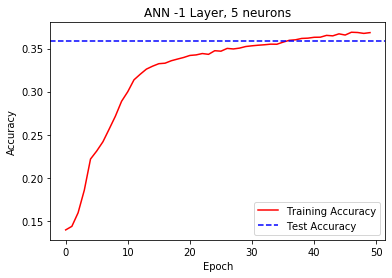

In [614]:
plt.plot(hist.history['acc'],'r', label = "Training Accuracy") #train accuracy
plt.axhline(y=accuracy[1], color='b', linestyle='--', label="Test Accuracy") #Test Accuracy
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title(f'ANN -1 Layer, 5 neurons')
plt.legend()
plt.show()

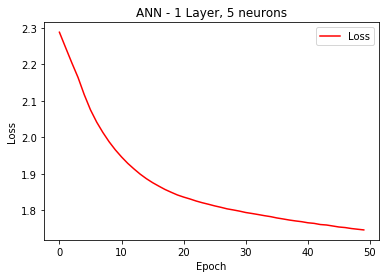

In [616]:
plt.plot(hist.history['loss'],'r', label = "Loss") #train accuracy
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'ANN - 1 Layer, 5 neurons')
plt.legend()
plt.show()

In [638]:
model = Sequential()
# model.add(Dense(units=5,activation='relu', input_shape=(32,32,3)))

model.add(Flatten(input_shape = (32,32,3))) #Flatten the images before processing otherwise use 3072 vectors
model.add(Dense(100, activation="sigmoid")) #I can use relu here as well
model.add(Dense(10,activation="sigmoid")) #Relu is not used in last layer
# model.add(Dense(1,activation = "sigmoid"))

# model.compile(optimizer="adam", loss = "spatial_categorical_crossentropy", metrics= ["accuracy"])
tf.keras.optimizers.SGD(lr=0.5) #Adjusting learninig rate

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
#loss is sparse_categorical_cross entropy if normal classes are used (0 to 9)
#loss is categorical_cross entropy if one hot vector classes are used

hist = model.fit(X_train, Y_train_hot, epochs=20) #normalized the images by dividing by 255 for sigmoid activation between 0 & 1

Epoch 1/20
50000/50000 [==============================] - 7s 132us/sample - loss: 2.1425 - acc: 0.2583
Epoch 2/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.9519 - acc: 0.3261
Epoch 3/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.8738 - acc: 0.3484
Epoch 4/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.8305 - acc: 0.3609
Epoch 5/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.8004 - acc: 0.3717
Epoch 6/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.7770 - acc: 0.3820
Epoch 7/20
50000/50000 [==============================] - 6s 128us/sample - loss: 1.7572 - acc: 0.3874
Epoch 8/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.7388 - acc: 0.3942
Epoch 9/20
50000/50000 [==============================] - 6s 129us/sample - loss: 1.7228 - acc: 0.3994
Epoch 10/20
50000/50000 [==============================] - 7s 131us/sampl

In [639]:
accuracy = model.evaluate(X_test,Y_test_hot)

10000/10000 [==============================] - 1s 103us/sample - loss: 1.5973 - acc: 0.4388


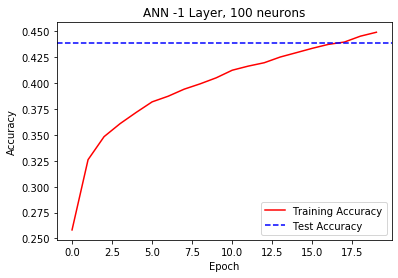

In [640]:
plt.plot(hist.history['acc'],'r', label = "Training Accuracy") #train accuracy
plt.axhline(y=accuracy[1], color='b', linestyle='--', label="Test Accuracy") #Test Accuracy
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title(f'ANN -1 Layer, 100 neurons')
plt.legend()
plt.show()

# BUILDING MODEL C-NN

In [632]:
model_cnn = Sequential([
    
    layers.Conv2D(filters=32, input_shape=(32,32,3), activation = "relu" , kernel_size = (3,3) ), #add a comma at the end
    layers.MaxPooling2D(2,2), #add comma
    layers.Dropout(0),
    
    layers.Conv2D(filters=64, activation = "relu" , kernel_size = (3,3) ), 
    layers.MaxPooling2D(2,2), 
    layers.Dropout(1),
    
    #dense
    layers.Flatten(),
    layers.Dense(64,activation="relu"), 
    layers.Dense(10, activation = "softmax") #no need for comma
    
              ])

In [633]:
# tf.keras.optimizers.SGD(lr=0.8) #Adjusting learninig rate

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#loss is sparse_categorical_cross entropy if normal classes are used (0 to 9)
#loss is categorical_cross entropy if one hot vector classes are used

In [634]:
hist_cnn = model_cnn.fit(X_train, Y_train_hot, epochs=10)

Epoch 1/10
50000/50000 [==============================] - 30s 609us/sample - loss: 1.5111 - acc: 0.4546
Epoch 2/10
50000/50000 [==============================] - 29s 589us/sample - loss: 1.1549 - acc: 0.5951
Epoch 3/10
50000/50000 [==============================] - 31s 614us/sample - loss: 1.0222 - acc: 0.6452
Epoch 4/10
50000/50000 [==============================] - 32s 644us/sample - loss: 0.9442 - acc: 0.6736
Epoch 5/10
50000/50000 [==============================] - 30s 607us/sample - loss: 0.8825 - acc: 0.6930
Epoch 6/10
50000/50000 [==============================] - 30s 605us/sample - loss: 0.8331 - acc: 0.7092
Epoch 7/10
50000/50000 [==============================] - 30s 599us/sample - loss: 0.7845 - acc: 0.7288
Epoch 8/10
50000/50000 [==============================] - 30s 601us/sample - loss: 0.7493 - acc: 0.7397
Epoch 9/10
50000/50000 [==============================] - 30s 603us/sample - loss: 0.7159 - acc: 0.7503
Epoch 10/10
50000/50000 [==============================] - 30s 6

In [635]:
accuracy_cnn = model_cnn.evaluate(X_test,Y_test_hot)

10000/10000 [==============================] - 2s 224us/sample - loss: 0.9665 - acc: 0.6789


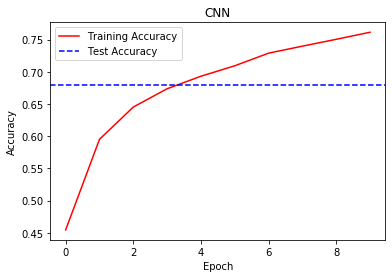

In [636]:
plt.plot(hist_cnn.history['acc'],'r', label = "Training Accuracy") #train accuracy
plt.axhline(y=accuracy_cnn[1], color='b', linestyle='--', label="Test Accuracy") #Test Accuracy
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title(f'CNN')
plt.legend()
plt.show()

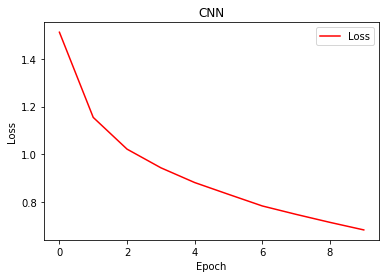

In [637]:
plt.plot(hist_cnn.history['loss'],'r', label = "Loss") #train accuracy
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'CNN')
plt.legend()
plt.show()

In [623]:
# Y_pred = np.zeros(len(X_test))

# Y_pred = model_cnn.predict(X_test)
# Y_pred.argmax(axis=1)

# All Accuracies

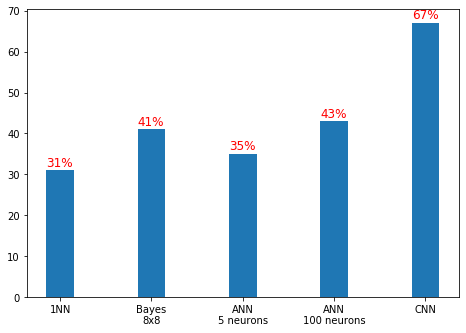

In [694]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["1NN","Bayes\n8x8","ANN\n5 neurons","ANN\n100 neurons","CNN"]
all_test_accuracies = [31,41,35,43,67]
ax.bar(labels,all_test_accuracies, width=0.3)

for i, v in enumerate(all_test_accuracies):
    ax.text(i-0.15 , v + 1, str(v)+"%", 
            color = 'red', size=12)
plt.show()